<h1><center>DSA 4212: Year 2017-2018</center></h1>
<h3><center> Assignment 2 (Deadline: 17/11/2017, 23:59, To Be submitted on the IVLE )</center></h3>
<h2><center> Group Number: 07 </center></h2>
<h3><center> Naming convention for IVLE submission: assignment_2_XX.ipynb </center></h2>





In [1]:
from __future__ import division, print_function
from builtins import range

%matplotlib inline
import autograd.numpy as np
from autograd import grad
np.random.seed(123)
import time as time
import matplotlib.pyplot as plt
import pandas as pd
import os as os
from PIL import Image  
import time as time

# Exercise 1: Film Recommendation

### Data Dowload
1. Download the "ml-latest-small.zip" file available at: 
https://goo.gl/gNQimd
2. Unzip the file in the directory of your choice. We will be exploiting the file: ratings.csv 


In [2]:
path = "/Users/garethalex/Desktop/Year 4/DSA4212/dataset/ml-latest-small"
file = "ratings.csv"
df = pd.read_csv(os.path.join(path, file))
print( df[:5] )

data = df.values[:,:3]
n_ratings = len(data)
n_users = len(np.unique(data[:,0]))
n_films = len(np.unique(data[:,1]))

#shuffle the data
data = data[np.random.permutation(n_ratings),:]
print(data[:5])
print(" User:{} \n Films:{}\n Ratings:{} \n Sparsity:{}%".format(n_users, n_films, n_ratings, 100*n_ratings / (n_users*n_films)))

   userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205
[[  2.30000000e+01   1.62500000e+03   4.50000000e+00]
 [  5.64000000e+02   2.80100000e+03   3.00000000e+00]
 [  6.65000000e+02   1.54100000e+03   3.00000000e+00]
 [  5.74000000e+02   4.95300000e+04   4.00000000e+00]
 [  4.72000000e+02   8.41000000e+02   4.00000000e+00]]
 User:671 
 Films:9066
 Ratings:100004 
 Sparsity:1.6439141608663477%


In [3]:
#split train / test data
n_ratings = len(data)
n_train = int(n_ratings * 0.7)
data_train = data[:n_train,:]
data_test = data[n_train:,:]


First column is the userId, the second column is the movieId, and the third column is the rating. Your task is to develop an algorithm that can predict the rating of given user for a given film. You will train your algorithm on the training set "data_train" and test performances on the test set contained in "data_train".

In [4]:
def RMSE_predictions(true_ratings, predictions):
    return np.sqrt(np.mean( (true_ratings - predictions)**2 ))

Let us first look at the performaces of the most naive and useless prediction: a random prediction.

In [5]:
random_predictions = 1 + 4*np.random.random(size=len(data_test))
RMSE_random_predictions =  RMSE_predictions(data_test[:,2], random_predictions)
print("RMSE of random predictions = ", RMSE_random_predictions)

RMSE of random predictions =  1.6606909353


Let us now look at the performaces of a slightly less naive and but as useless prediction: the global average.

In [6]:
global_average = np.zeros(len(data_test)) + np.mean(data_train[:,2])
RMSE_global_average =  RMSE_predictions(data_test[:,2], global_average)
print("RMSE of global_average predictions = ", RMSE_global_average)

RMSE of global_average predictions =  1.05864521719


### Task:
Use the ideas introduced in chapter "Matrix Completion" to build a recommendation system that can predict the ratings of the data contained in "data_test". You can only use the data contained in "data_train" to fit your model.

### Fit a naive movie/user mean model

In [7]:
def Train_Dict(data_train, Type):
    ### Input: 
    ### Type = 1: Movie Mean; 
    ### Type = 0: User mean
    
    movie_user_train = data_train[:,Type]
    uniq_movie_user_train = np.unique(movie_user_train)
    rating_train = data_train[:,2]
    mean_dict = dict()
    
    for movie_user in uniq_movie_user_train:
        idx_movie_user = (movie_user_train == movie_user)
        selected = rating_train[idx_movie_user]
        mean_dict[movie_user] = [np.mean(selected), len(selected)]
    
    return mean_dict

def movie_user_avg(alpha, data_train, data_test, Type):
    mean_dict = Train_Dict(data_train, Type)

    # initialize with global mean
    rating_train = data_train[:,2]
    global_average = np.mean(rating_train)
    movie_user_average = np.zeros(len(data_test)) + global_average
    
    for i in range(len(data_test)):
        line = data_test[i,:]
        movie_user = line[Type]
        if movie_user in mean_dict:
            avg = mean_dict[movie_user][0]
            num_of_movie_user = mean_dict[movie_user][1]
            movie_user_average[i] = (alpha*global_average + num_of_movie_user*avg)\
                                /(alpha + num_of_movie_user)
    return movie_user_average


In [8]:
def loss_movie(alpha = 0):
    movie_average = movie_user_avg(alpha, data_train, data_test, 1)
    rating_test = data_test[:,2]
    return RMSE_predictions(rating_test, movie_average)

def loss_user(alpha = 0):
    user_average = movie_user_avg(alpha, data_train, data_test, 0)
    rating_test = data_test[:,2]
    return RMSE_predictions(rating_test, user_average)

In [9]:
start = time.time()

RMSE_movie_average =  loss_movie()
print("RMSE of movie_avg predictions = ", RMSE_movie_average)

end = time.time()
print("time used: ", end - start)

RMSE of movie_avg predictions =  1.00045536632
time used:  0.9477970600128174


In [128]:
start = time.time()

RMSE_user_average =  loss_user()
print("RMSE of user_avg predictions = ", RMSE_user_average)

end = time.time()
print("time used: ", end - start)

RMSE of user_avg predictions =  0.964961529141
time used:  0.1327211856842041


The user average gives a shorter time and better performance

### We then tried to see the effect of alpha. However, it seems the RMSE is generally increasing versus alpha. Thus, we will select alpha to be zero (simple user mean case). We then fit the residual with the type parameter.

First, we get the residuals (In-sample and test data)

In [129]:
user_average = movie_user_avg(0, data_train, data_train, 0)
rating_train = data_train[:,2]
resid = rating_train - user_average

user_average_test = movie_user_avg(0, data_train, data_test, 0)
rating_test = data_test[:,2]
resid_test = rating_test - user_average_test

In [130]:
print("The in-sample error is: ", RMSE_predictions(rating_train, user_average))
print("The test error is: ", RMSE_predictions(rating_test, user_average_test))

The in-sample error is:  0.953218402065
The test error is:  0.964961529141


Next, we tried to approximate the residuals

In [133]:
# Pre-define some useful global variables
users_train = data_train[:,0]
movies_train = data_train[:,1]
users_test = data_test[:,0]
movies_test = data_test[:,1]

uniq_users = np.unique(users_train)
uniq_movies = np.unique(movies_train)

n_users = len(uniq_users)
n_movies = len(uniq_movies)

max_user = max(data[:,0])
max_movie = max(data[:,1])

users_index = users_train.astype(int) - 1
movies_index = movies_train.astype(int) - 1

test_users_index = users_test.astype(int) - 1
test_movies_index = movies_test.astype(int) - 1

In [134]:
# Define the product of features, which is also our approximated residuals
def matrixproduct(w_user, w_movie, users_index, movies_index):
    w_user_used = w_user[users_index]
    w_movie_used = w_movie[movies_index]
    return np.sum(np.multiply(w_user_used, w_movie_used), axis = 1)

# Define the loss function
def loss_total(w_user, w_movie, users_index, movies_index, resid, C = 0):
    dot_products = matrixproduct(w_user, w_movie, users_index, movies_index)
    
    user_penalty = np.mean(w_user[np.unique(users_index)] ** 2)    
    movie_penalty = np.mean(w_movie[np.unique(movies_index)] ** 2)
    return np.mean((resid - dot_products) ** 2) + C * user_penalty + C * movie_penalty


grad_user = grad(loss_total, argnum=0)
grad_movie = grad(loss_total, argnum=1)

In [351]:
def run(n_categ, nb_iterations, learning_rate, C, init_type):

    # Initialize user vectors, random or constant:
    if init_type == "random":
        w_user = np.random.random((int(max_user), n_categ))
        w_movie = np.random.random((int(max_movie), n_categ))
    elif init_type == "const":
        w_user = np.zeros((int(max_user), n_categ)) + 0.0001
        w_movie = np.zeros((int(max_movie), n_categ)) + 0.0001

    # Initialize loss histories
    loss_history = np.zeros(nb_iterations)
    loss_test_history = np.zeros(nb_iterations)
    actual_loss_history = np.zeros(nb_iterations)
    actual_loss_test_history = np.zeros(nb_iterations)

    for i in range(nb_iterations):
        # track the progress
        if i % 50 == 0:
            print(i, " have been done.")

        # GD on users first, then GD on movies
        # gradient along users
        gradient_user = grad_user(w_user, w_movie, users_index, movies_index, resid, C)
        w_user = w_user - learning_rate * gradient_user
        
        # gradient along movies
        gradient_movie = grad_movie(w_user, w_movie, users_index, movies_index, resid, C)
        w_movie = w_movie - learning_rate * gradient_movie

        #keep track of loss
        loss_history[i] = loss_total(w_user, w_movie, users_index, movies_index, resid, C)
        loss_test_history[i] = loss_total(w_user, w_movie, test_users_index, test_movies_index, resid_test, C)
        actual_loss_history[i] = RMSE_predictions(rating_train, user_average \
                                    + matrixproduct(w_user, w_movie, users_index, movies_index))
        actual_loss_test_history[i] = RMSE_predictions(rating_test, user_average_test \
                                        + matrixproduct(w_user, w_movie, test_users_index, test_movies_index))
    return loss_history, loss_test_history, actual_loss_history, actual_loss_test_history

We tried different number of categories, different learning rates and different penalty value. Empirically, the model reduce more error when number of category is one. 

We also changed initialization conditions. For random initialization, gradient descent may have some turbulance somewhere is the randomized values are not scaled to a smaller size. For constant initialization, we cannot initialize with all zeros. We chose to initialize with some small constant values based on our experiments.

It appeared the following one gives the best result.

In [339]:
n_categ = 1
nb_iterations = 300
learning_rate = 170
C = 0.1
loss_history, loss_test_history, actual_loss_history, actual_loss_test_history = \
    run(n_categ, nb_iterations, learning_rate, C, "const")


0  have been done.
50  have been done.
100  have been done.
150  have been done.
200  have been done.
250  have been done.


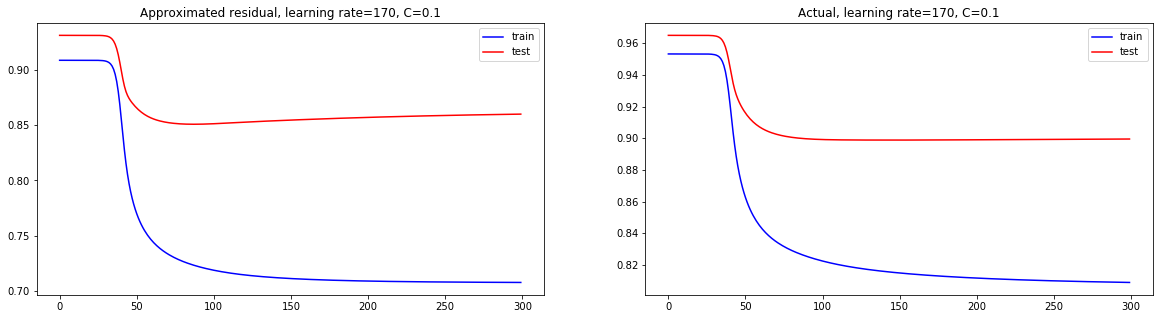

In [340]:
plt.rcParams['figure.figsize'] = (20,5)

plt.subplot(1,2,1)
plt.plot(loss_history, "-b", label = "train")
plt.legend()
plt.plot(loss_test_history, "-r", label = "test")
plt.legend()
plt.title("Approximated residual, learning rate=" + str(learning_rate) + ", C=" + str(C))

plt.subplot(1,2,2)
plt.plot(actual_loss_history, "-b", label = "train")
plt.legend()
plt.plot(actual_loss_test_history, "-r", label = "test")
plt.legend()
plt.title("Actual, learning rate=" + str(learning_rate) + ", C=" + str(C))

Let's see the test errors:

In [341]:
print("Test error without factor model: ", RMSE_predictions(rating_test, user_average_test))
print("Test error with factor model: ", actual_loss_test_history[-1])

Test error without factor model:  0.964961529141
Test error with factor model:  0.899505341893


The factor model reduces our test error.

In order to compare, we see the case when number of categories is greater than 1.

In [345]:
# Set initial values
n_categ = 3
nb_iterations = 300
learning_rate = 140
C = 0.01
loss_history, loss_test_history, actual_loss_history, actual_loss_test_history = \
    run(n_categ, nb_iterations, learning_rate, C, "const")



0  have been done.
50  have been done.
100  have been done.
150  have been done.
200  have been done.
250  have been done.


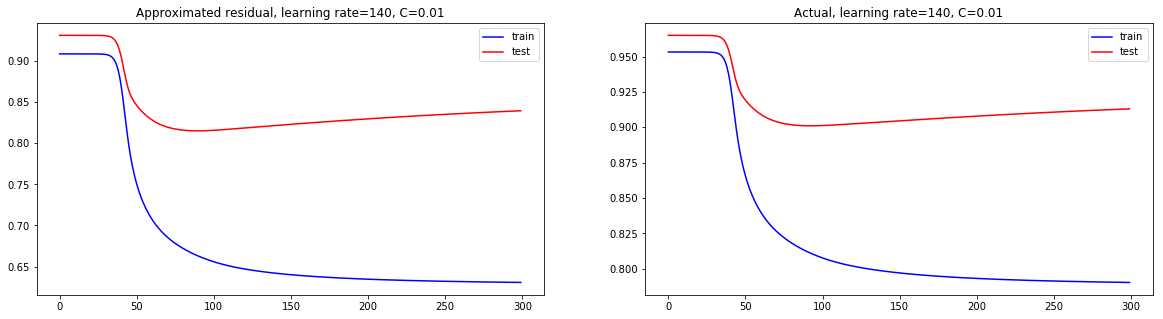

In [346]:
plt.rcParams['figure.figsize'] = (20,5)

plt.subplot(1,2,1)
plt.plot(loss_history, "-b", label = "train")
plt.legend()
plt.plot(loss_test_history, "-r", label = "test")
plt.legend()
plt.title("Approximated residual, learning rate=" + str(learning_rate) + ", C=" + str(C))

plt.subplot(1,2,2)
plt.plot(actual_loss_history, "-b", label = "train")
plt.legend()
plt.plot(actual_loss_test_history, "-r", label = "test")
plt.legend()
plt.title("Actual, learning rate=" + str(learning_rate) + ", C=" + str(C))

In [347]:
print("Test error without factor model: ", RMSE_predictions(rating_test, user_average_test))
print("Test error with factor model: ", actual_loss_test_history[-1])

Test error without factor model:  0.964961529141
Test error with factor model:  0.913014714001


It is not as good as the first one.

## Appendix 1: The effect of alpha

In [125]:
offset = 200
N = 50
loss_history = np.zeros(N)
loss_test_history = np.zeros(N)
i = 0

for alpha in range(offset, offset+N):
    if i % 10 == 0:
        print(i)
    loss_history[i] = loss_user(alpha)
    i += 1

0
10
20
30
40


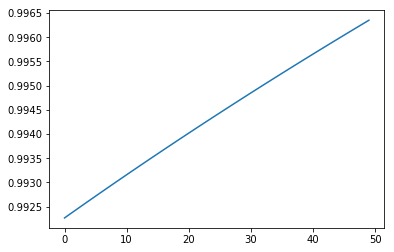

In [126]:
plt.plot(loss_history)

#### Conclusion: No matter how we changed the offset value, the loss appeared to be increasing versus alpha. Thus we just set alpha to zero.

## Appendix 2: The effect of random initialization in factor model

The below example shows the turbulance we mentioned above.

In [352]:
n_categ = 1
nb_iterations = 300
learning_rate = 170
C = 0.1
loss_history, loss_test_history, actual_loss_history, actual_loss_test_history = \
    run(n_categ, nb_iterations, learning_rate, C, "random")


0  have been done.
50  have been done.
100  have been done.
150  have been done.
200  have been done.
250  have been done.


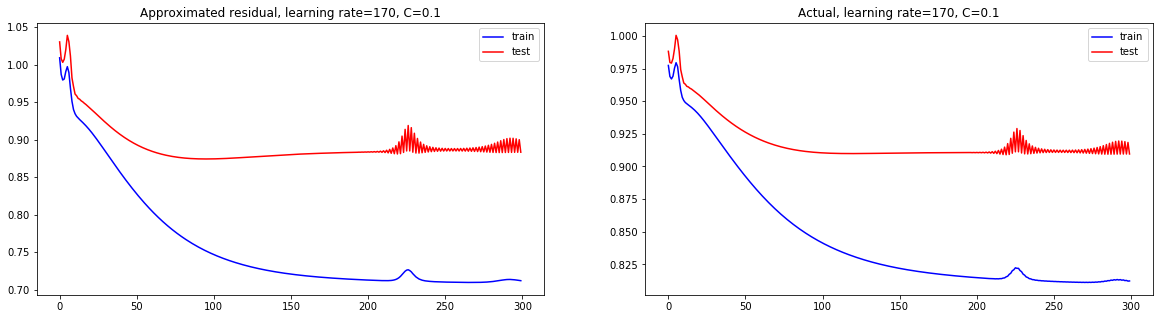

In [353]:
plt.rcParams['figure.figsize'] = (20,5)

plt.subplot(1,2,1)
plt.plot(loss_history, "-b", label = "train")
plt.legend()
plt.plot(loss_test_history, "-r", label = "test")
plt.legend()
plt.title("Approximated residual, learning rate=" + str(learning_rate) + ", C=" + str(C))

plt.subplot(1,2,2)
plt.plot(actual_loss_history, "-b", label = "train")
plt.legend()
plt.plot(actual_loss_test_history, "-r", label = "test")
plt.legend()
plt.title("Actual, learning rate=" + str(learning_rate) + ", C=" + str(C))

# Exercise 2: image reconstruction

This exercise consists in reconstructing an image from a noisy versoin of it. 
1. The original image, "NUS.png", can be thought of as a matrix $M$.
2. One only observes a noissy version of it, $N$, defined as
$$
N_{i,j} = \mathbf{Poisson}(M_{i,j}).
$$
3. Your task is to reconstruct a good approximation of the original image based only on the noisy version of it.

In [2]:
#load the data
path = "/Users/garethalex/Desktop/Year 4/DSA4212/dataset/"
file = "NUS.png"

def read_image(path, file):
    """
    read an image, convert it to grayscale, normalize intensity pixels to (0,1)
    """
    img = np.array(Image.open(os.path.join(path, file)))
    return np.mean(img, axis=2) / 255.

img = read_image(path, file)


In [3]:
#let us create a noisy version of it
dim_x, dim_y = img.shape
img_noisy = np.random.poisson(img)

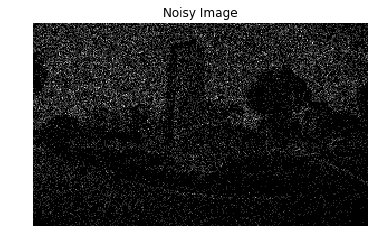

In [4]:
plt.imshow(img_noisy, cmap = "gray")
plt.axis("off")
plt.title("Noisy Image")

In [5]:
#expand the matrix into an array
noisy = np.asarray(img_noisy).reshape(-1)
original=np.asarray(img).reshape(-1)
original.shape

(54600,)

### Firstly, we apply rank penalized regression

In [9]:
def soft_thresholding(x, eta):
    xx = np.copy(x)
    xx[np.abs(xx) <= eta] = 0.
    xx[xx > eta] = xx[xx > eta] - eta
    xx[xx < -eta] = xx[xx < -eta] + eta    
    return xx

In [10]:
def proximal_op(X, threshold):
    U,d,V = np.linalg.svd(X)
    d = soft_thresholding(d, threshold)
    dimx, dimy = X.shape
    r = len(d) #min(N,p)
    D = np.zeros((dimx, dimy))
    D[:r, :r] =  np.diag(d[:r])
    return np.dot(U, np.dot(D,V))


In [11]:
def F(X, data):
    exp_X=np.exp(X)
    return np.mean( exp_X - np.multiply(data,X) )

grad_F = grad(F,argnum=0)

def loss(X, data, C):
    _,d,_ = np.linalg.svd(X)
    return F(X, data) + C * np.sum(d)
    

In [12]:
X = np.random.random((dim_x, dim_y))


In [13]:
X = np.random.random((dim_x, dim_y))
nb_iteration = 2500
learning_rate = 300
loss_history = np.zeros(nb_iteration)
C = 0.0001

for k in range(nb_iteration):
    # Track progress
    if k % 500 == 0:
        print(k, " is done.")
        
    #gradient along F
    gradient = grad_F(X, img_noisy)
    X = X - learning_rate * gradient
    
    #proximal step along nuclear norm
    threshold = C * learning_rate
    X = proximal_op(X, threshold)
    
    #keep track of loss
    loss_history[k] = loss(X, img_noisy, C)

0  is done.


KeyboardInterrupt: 

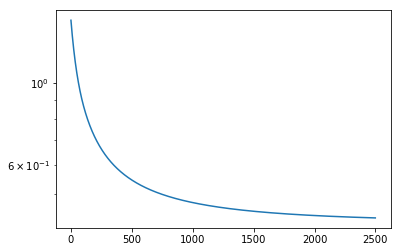

In [278]:
plt.plot(loss_history, "-")
plt.yscale("log")

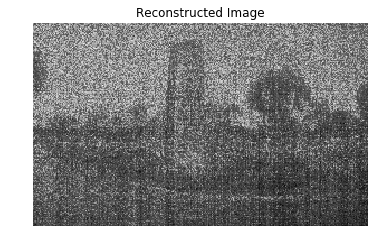

In [279]:
plt.imshow(X, cmap = "gray")
plt.axis("off")
plt.title("Reconstructed Image")

### Secondly, we tried different smooth regulator

##### 1.Row + Column squared difference, exponentially transformed 

In [207]:
# ensures smoothnes
def G(X):
    exp_X = np.exp(X)
#     return np.mean((exp_X.flatten()[1:] - exp_X.flatten()[:-1])**2)
    return np.mean( (exp_X[1:,:]-exp_X[:-1,:])**2 ) + np.mean( (exp_X[:, 1:]-exp_X[:,:-1])**2 )

def loss(X, data, C):
    return F(X, data) + C*G(X)

grad_loss = grad(loss,argnum=0)

In [266]:
X = np.random.random((dim_x, dim_y))
nb_iteration = 500
learning_rate = 1
loss_history = np.zeros(nb_iteration)
C = 4
alpha = 0.5  #param for backtracking approach

for k in range(nb_iteration):
    # Track the progress
    if k % 100 == 0:
        print(k, " is done.")
    
    #gradient along F
    gradient = grad_loss(X, img_noisy, C)
    
    #backtracking approach
    learning_rate = learning_rate * 10  #start with a large learning rate 
    norm_gradient = np.linalg.norm(gradient)
    while loss(X - learning_rate * gradient, img_noisy, C) > loss(X,img_noisy, C) \
                                                            - alpha * learning_rate * norm_gradient**2:
        learning_rate = learning_rate / 2
    
    #gradient descent update
    X = X - learning_rate * gradient
    
    #keep track of loss
    loss_history[k] = loss(X, img_noisy, C)

0  is done.
100  is done.
200  is done.
300  is done.
400  is done.


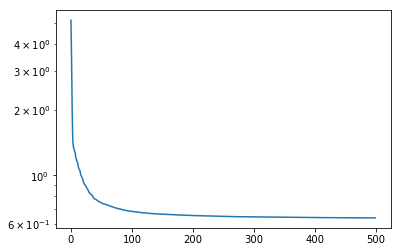

In [267]:
plt.plot(loss_history, "-")
plt.yscale("log")

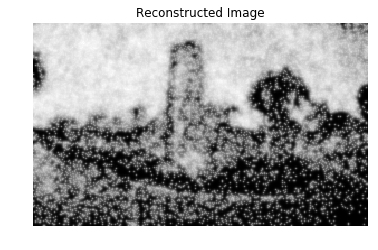

In [268]:
plt.imshow(X, cmap = "gray")
plt.axis("off")
plt.title("Reconstructed Image")

##### 2.Row + Column squared difference, not transformed 

In [280]:
# ensures smoothnes
def G(X):
    exp_X = np.exp(X)
#     return np.mean((exp_X.flatten()[1:] - exp_X.flatten()[:-1])**2)
    return np.mean( (X[1:,:]-X[:-1,:])**2 ) + np.mean( (X[:, 1:]-X[:,:-1])**2 )

def loss(X, data, C):
    return F(X, data) + C*G(X)

grad_loss = grad(loss,argnum=0)

In [297]:
X = np.random.random((dim_x, dim_y))
nb_iteration = 200
learning_rate = 1
loss_history = np.zeros(nb_iteration)
C = 1
alpha = 0.5  #param for backtracking approach

for k in range(nb_iteration):
    # Track the progress
    if k % 100 == 0:
        print(k, " is done.")
    
    #gradient along F
    gradient = grad_loss(X, img_noisy, C)
    
    #backtracking approach
    learning_rate = learning_rate * 10  #start with a large learning rate 
    norm_gradient = np.linalg.norm(gradient)
    while loss(X - learning_rate * gradient, img_noisy, C) > loss(X,img_noisy, C) \
                                                            - alpha * learning_rate * norm_gradient**2:
        learning_rate = learning_rate / 2
    
    #gradient descent update
    X = X - learning_rate * gradient
    
    #keep track of loss
    loss_history[k] = loss(X, img_noisy, C)

0  is done.
100  is done.


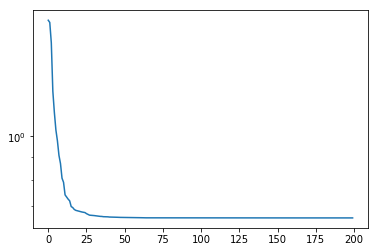

In [298]:
plt.plot(loss_history, "-")
plt.yscale("log")

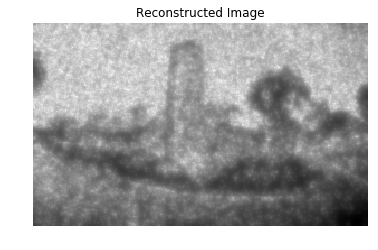

In [299]:
plt.imshow(X, cmap = "gray")
plt.axis("off")
plt.title("Reconstructed Image")

##### 3.Flatten squared difference, exponentially transformed 

In [301]:
# ensures smoothnes
def G(X):
    exp_X = np.exp(X)
    return np.mean((exp_X.flatten()[1:] - exp_X.flatten()[:-1])**2)

def loss(X, data, C):
    return F(X, data) + C*G(X)

grad_loss = grad(loss,argnum=0)

In [308]:
X = np.random.random((dim_x, dim_y))
nb_iteration = 250
learning_rate = 1
loss_history = np.zeros(nb_iteration)
C = 3
alpha = 0.5  #param for backtracking approach

for k in range(nb_iteration):
    # Track the progress
    if k % 100 == 0:
        print(k, " is done.")
    
    #gradient along F
    gradient = grad_loss(X, img_noisy, C)
    
    #backtracking approach
    learning_rate = learning_rate * 10  #start with a large learning rate 
    norm_gradient = np.linalg.norm(gradient)
    while loss(X - learning_rate * gradient, img_noisy, C) > loss(X,img_noisy, C) \
                                                            - alpha * learning_rate * norm_gradient**2:
        learning_rate = learning_rate / 2
    
    #gradient descent update
    X = X - learning_rate * gradient
    
    #keep track of loss
    loss_history[k] = loss(X, img_noisy, C)

0  is done.
100  is done.
200  is done.


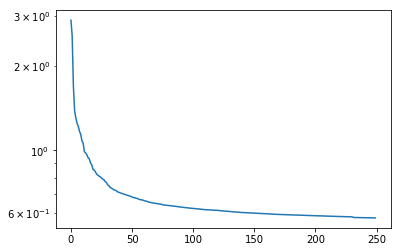

In [309]:
plt.plot(loss_history, "-")
plt.yscale("log")

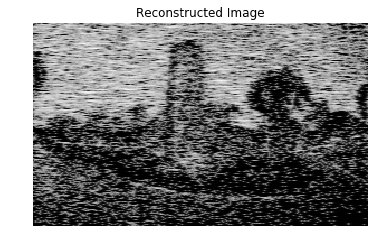

In [310]:
plt.imshow(X, cmap = "gray")
plt.axis("off")
plt.title("Reconstructed Image")

##### 4.Flatten absolute difference, exponentially transformed 

In [18]:
# ensures smoothnes
def G(X):
    exp_X = np.exp(X)
    return np.mean(np.abs(exp_X.flatten()[1:] - exp_X.flatten()[:-1]))

def loss(X, data, C):
    return F(X, data) + C*G(X)

grad_loss = grad(loss,argnum=0)

In [58]:
X = np.random.random((dim_x, dim_y))
nb_iteration = 250
learning_rate = 200
loss_history = np.zeros(nb_iteration)
C = 0.005
alpha = 0.5  #param for backtracking approach

for k in range(nb_iteration):
    # Track the progress
    if k % 100 == 0:
        print(k, " is done.")
    
    #gradient along F
    gradient = grad_loss(X, img_noisy, C)
    
    #backtracking approach
    learning_rate = learning_rate * 10  #start with a large learning rate 
    norm_gradient = np.linalg.norm(gradient)
    while loss(X - learning_rate * gradient, img_noisy, C) > loss(X,img_noisy, C) \
                                                            - alpha * learning_rate * norm_gradient**2:
        learning_rate = learning_rate / 2
    
    #gradient descent update
    X = X - learning_rate * gradient
    
    #keep track of loss
    loss_history[k] = loss(X, img_noisy, C)

0  is done.
100  is done.
200  is done.


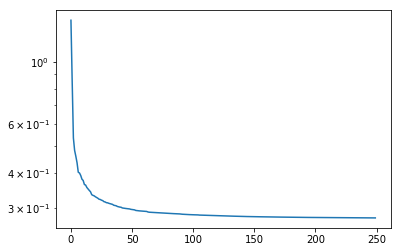

In [59]:
plt.plot(loss_history, "-")
plt.yscale("log")

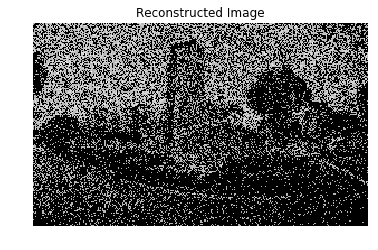

In [60]:
plt.imshow(X, cmap = "gray")
plt.axis("off")
plt.title("Reconstructed Image")